# Flight Delay Analysis & Prediction (2019–2023)

This notebook explores **U.S. flight delay data** (2019–2023) to understand:

- Which airlines and routes are most delay-prone?  
- How delays evolve over time (seasonality, trends)?  
- Can we **predict** whether a flight will be delayed using machine learning?

The project includes:
- Exploratory Data Analysis (EDA)
- Predictive modeling (Logistic Regression, Random Forest, XGBoost)
- Feature importance comparisons
- Key insights for airlines, airports, and passengers


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

In [3]:
# reading the dataset
df = pd.read_csv('/content/drive/MyDrive/airlines/flights_sample_3m.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000000 entries, 0 to 2999999
Data columns (total 32 columns):
 #   Column                   Dtype  
---  ------                   -----  
 0   FL_DATE                  object 
 1   AIRLINE                  object 
 2   AIRLINE_DOT              object 
 3   AIRLINE_CODE             object 
 4   DOT_CODE                 int64  
 5   FL_NUMBER                int64  
 6   ORIGIN                   object 
 7   ORIGIN_CITY              object 
 8   DEST                     object 
 9   DEST_CITY                object 
 10  CRS_DEP_TIME             int64  
 11  DEP_TIME                 float64
 12  DEP_DELAY                float64
 13  TAXI_OUT                 float64
 14  WHEELS_OFF               float64
 15  WHEELS_ON                float64
 16  TAXI_IN                  float64
 17  CRS_ARR_TIME             int64  
 18  ARR_TIME                 float64
 19  ARR_DELAY                float64
 20  CANCELLED                float64
 21  CANCELLA

## Data Cleaning

The raw dataset contained **3 million flights** (2019–2023) with:

- Flight details: date, airline, origin/destination airports  
- Schedule & timing: departure, arrival, delays  
- Delay causes: weather, carrier, security, etc.

I:
- Removed **cancelled flights**  
- Created a **DELAYED_FLAG** (delayed if ARR_DELAY > 15 minutes)  
- Handled missing values (e.g., NaNs in delay cause columns)


In [5]:
# correcting date formats and cleaning the set

df['FL_DATE'] = pd.to_datetime(df['FL_DATE'])
df.isna().sum().sort_values(ascending=False)

,0
CANCELLATION_CODE,2920860
DELAY_DUE_LATE_AIRCRAFT,2466137
DELAY_DUE_CARRIER,2466137
DELAY_DUE_SECURITY,2466137
DELAY_DUE_NAS,2466137
DELAY_DUE_WEATHER,2466137
ARR_DELAY,86198
ELAPSED_TIME,86198
AIR_TIME,86198
WHEELS_ON,79944


In [6]:
# handling NaNs:

# 1. NaNs in delay columns usually mean cancellations or diversions, i'm keeping cancellations separate by making a `CANCELLED_FLAG` column
df['CANCELLED_FLAG'] = (df['CANCELLED'] == 1).astype(int)

# 2. making a dataset that only includes flights that haven't been cancelled to analyse delays, and then dropping the delay NaNs
delay_df = df[df['CANCELLED_FLAG'] == 0]
delay_df = delay_df[delay_df['ARR_DELAY'].notna()]

# 3. delay flag (only for non-cancelled flights now)
delay_df = delay_df.copy()
delay_df['DELAYED_FLAG'] = (delay_df['ARR_DELAY'] > 15).astype(int)

# Exploratory Data Analysis

We began by answering key questions:

- Which airlines have the **highest delay rates**?  
- Which **routes** are most delay-prone?  
- What are major **causes** of delays?
- Does **time of day** or **month** affect delays?
- Which airlines have improved delay rates over time? Which of them have worsened?

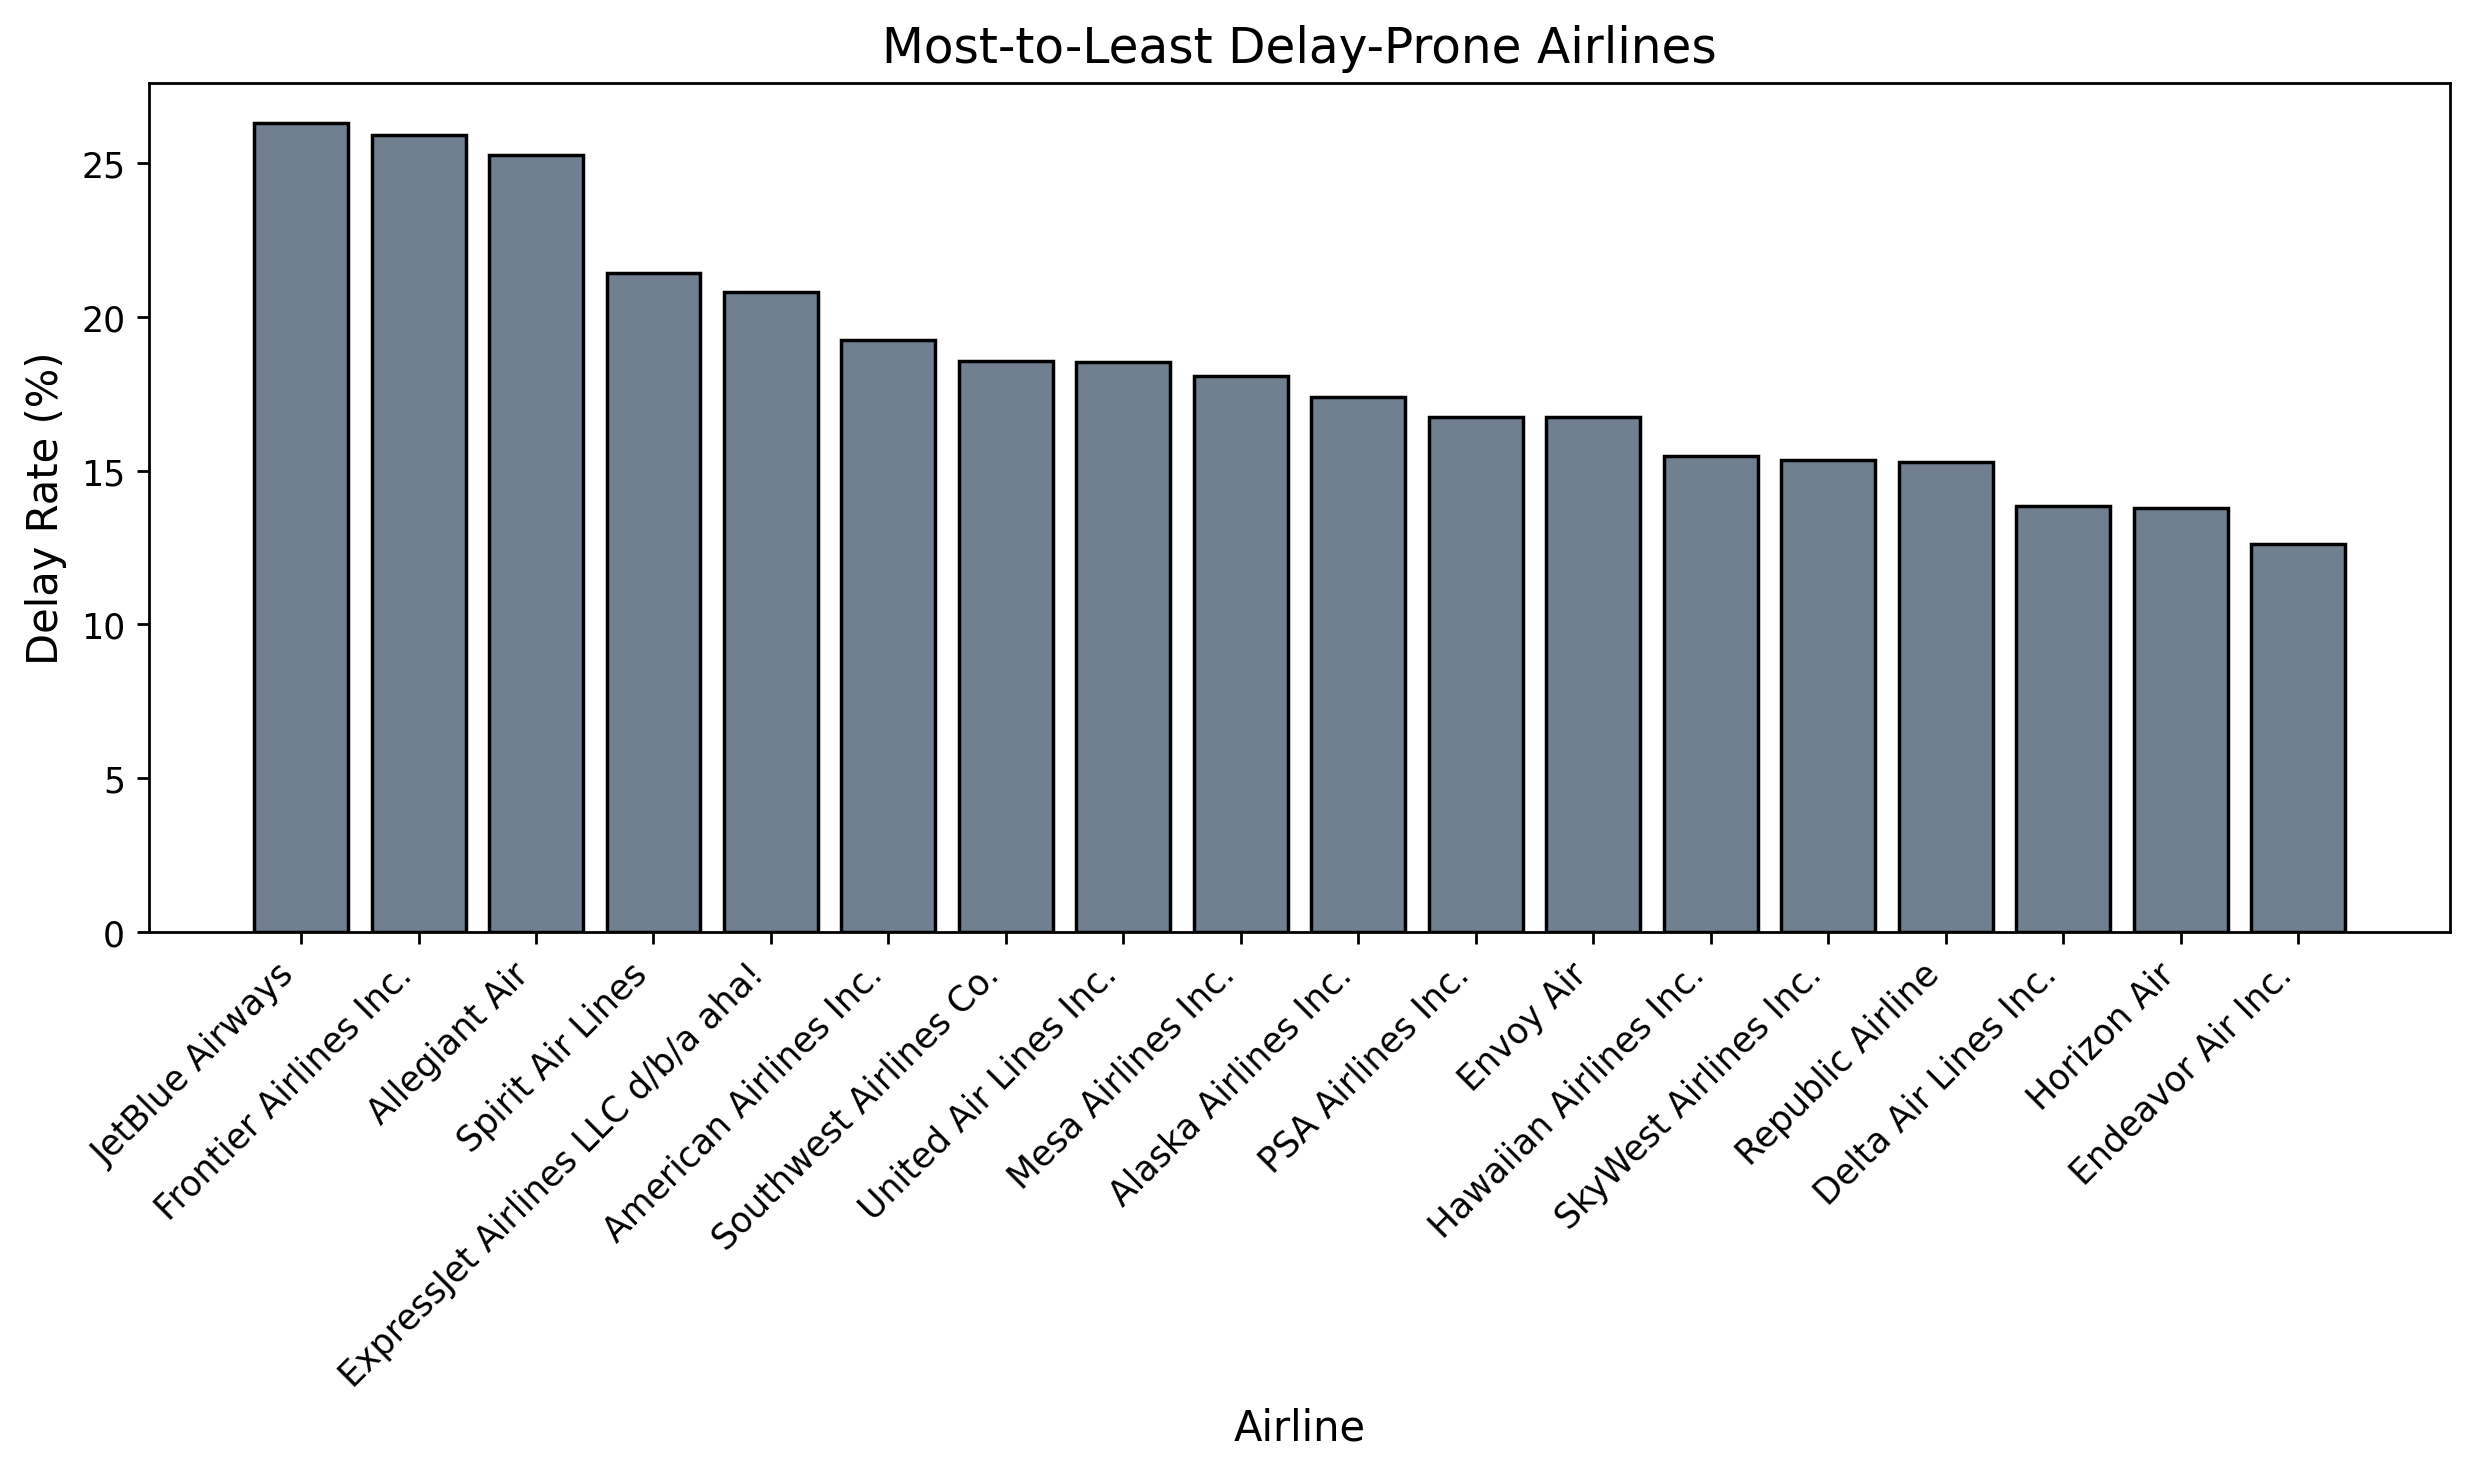

In [8]:
# most-least delay-prone airlines

# grouping by airline
airline_grouped = delay_df.groupby('AIRLINE')['DELAYED_FLAG']
airline_delay = airline_grouped.mean()
airline_stats = pd.DataFrame({'DELAY_RATE': airline_delay}).reset_index()
airline_stats = airline_stats.sort_values('DELAY_RATE', ascending = False)
#_______________________________________________________________________________

plt.figure(figsize = (10,6), dpi = 250)
plt.bar(airline_stats['AIRLINE'], airline_stats['DELAY_RATE']*100, color = 'slategrey', edgecolor = 'black')
plt.xlabel('Airline', fontsize = 12)
plt.xticks(rotation = 45, ha = 'right')
plt.ylabel('Delay Rate (%)', fontsize = 12)
plt.title('Most-to-Least Delay-Prone Airlines', fontsize = 14)

plt.tight_layout()
plt.show()

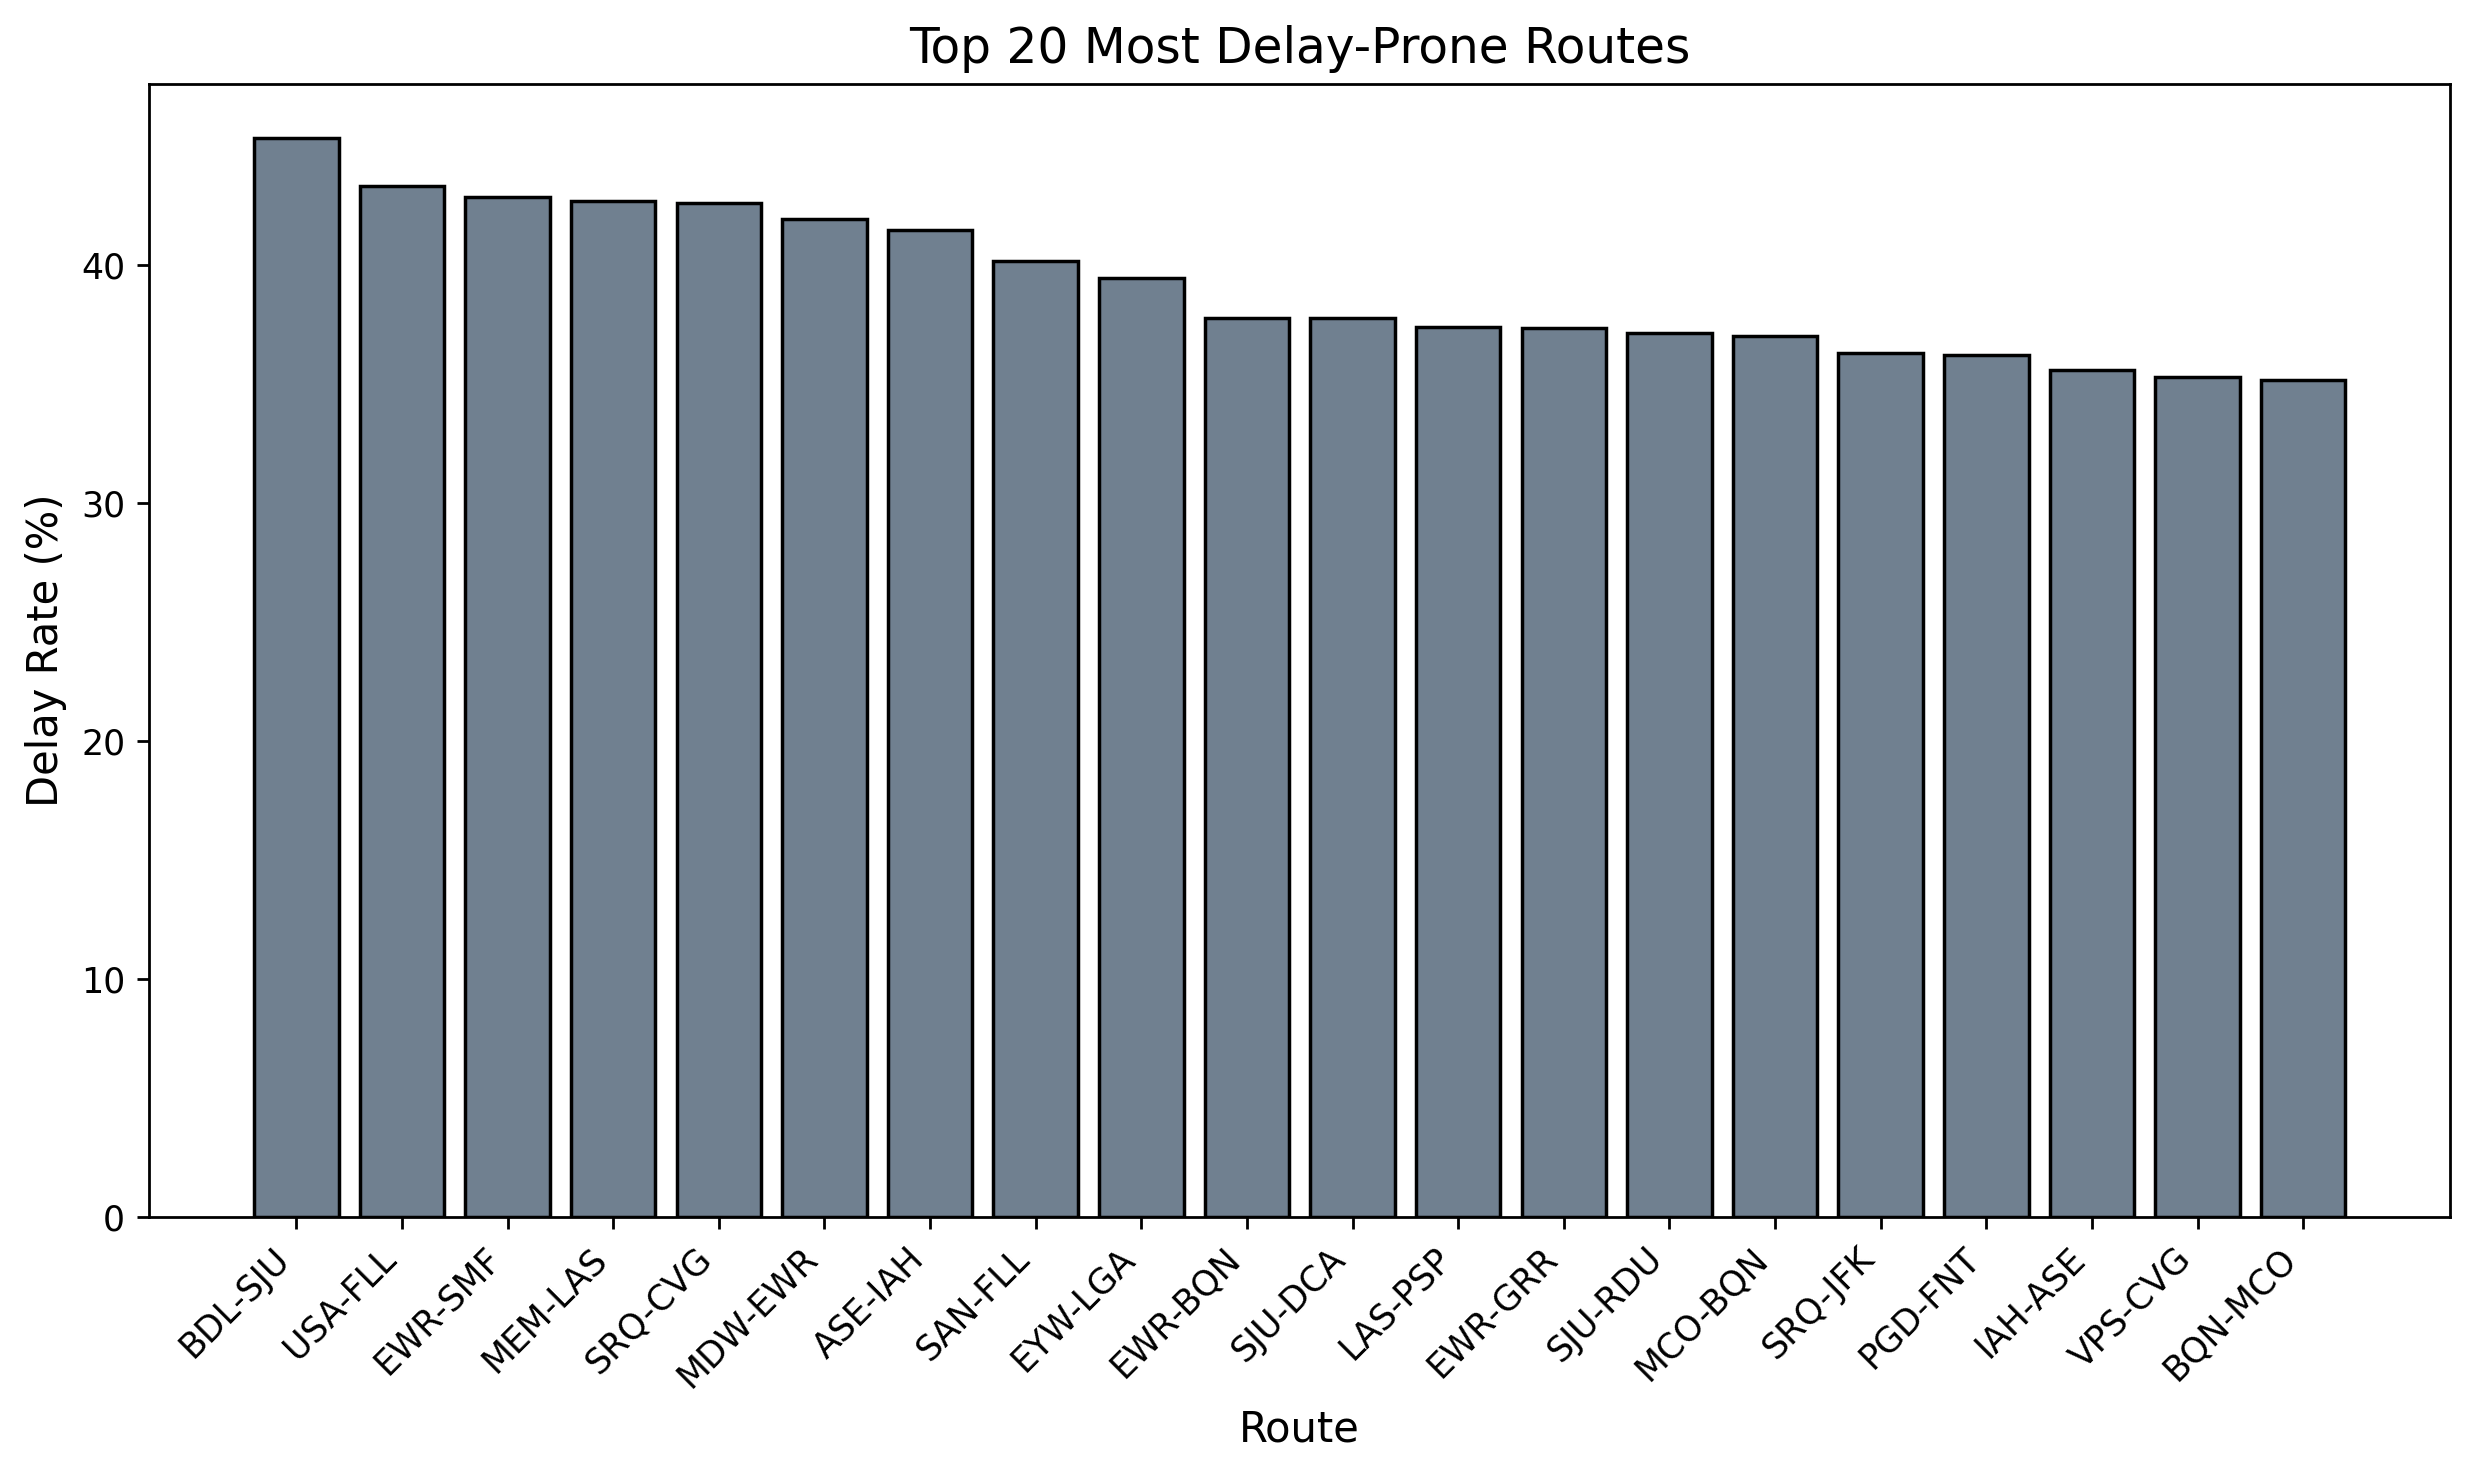

In [10]:
# most-least delay-prone routes

# grouping by route
route_grouped = delay_df.groupby(['ORIGIN','DEST'])['DELAYED_FLAG']

# mean delay rate
route_delay = route_grouped.mean()

# number of flights
route_count = route_grouped.count()

# combining
route_stats = pd.DataFrame({'delay_rate': route_delay, 'total_flights': route_count}).reset_index()

# filter: keep only routes with 100+ flights
route_stats = route_stats[route_stats['total_flights'] >= 100]

# sorting by delay rate
route_stats = route_stats.sort_values('delay_rate', ascending = False).head(20)

#_______________________________________________________________________________

# plotting

route_stats['ROUTE'] = route_stats['ORIGIN'] + '-' + route_stats['DEST']
plt.figure(figsize = (10,6), dpi = 250)
plt.bar(route_stats['ROUTE'], route_stats['delay_rate']*100, color='slategrey', edgecolor = 'black')
plt.xlabel('Route', fontsize = 12)
plt.xticks(rotation = 45, ha = 'right')
plt.ylabel('Delay Rate (%)', fontsize = 12)
plt.title('Top 20 Most Delay-Prone Routes', fontsize = 14)

plt.tight_layout()
plt.show()

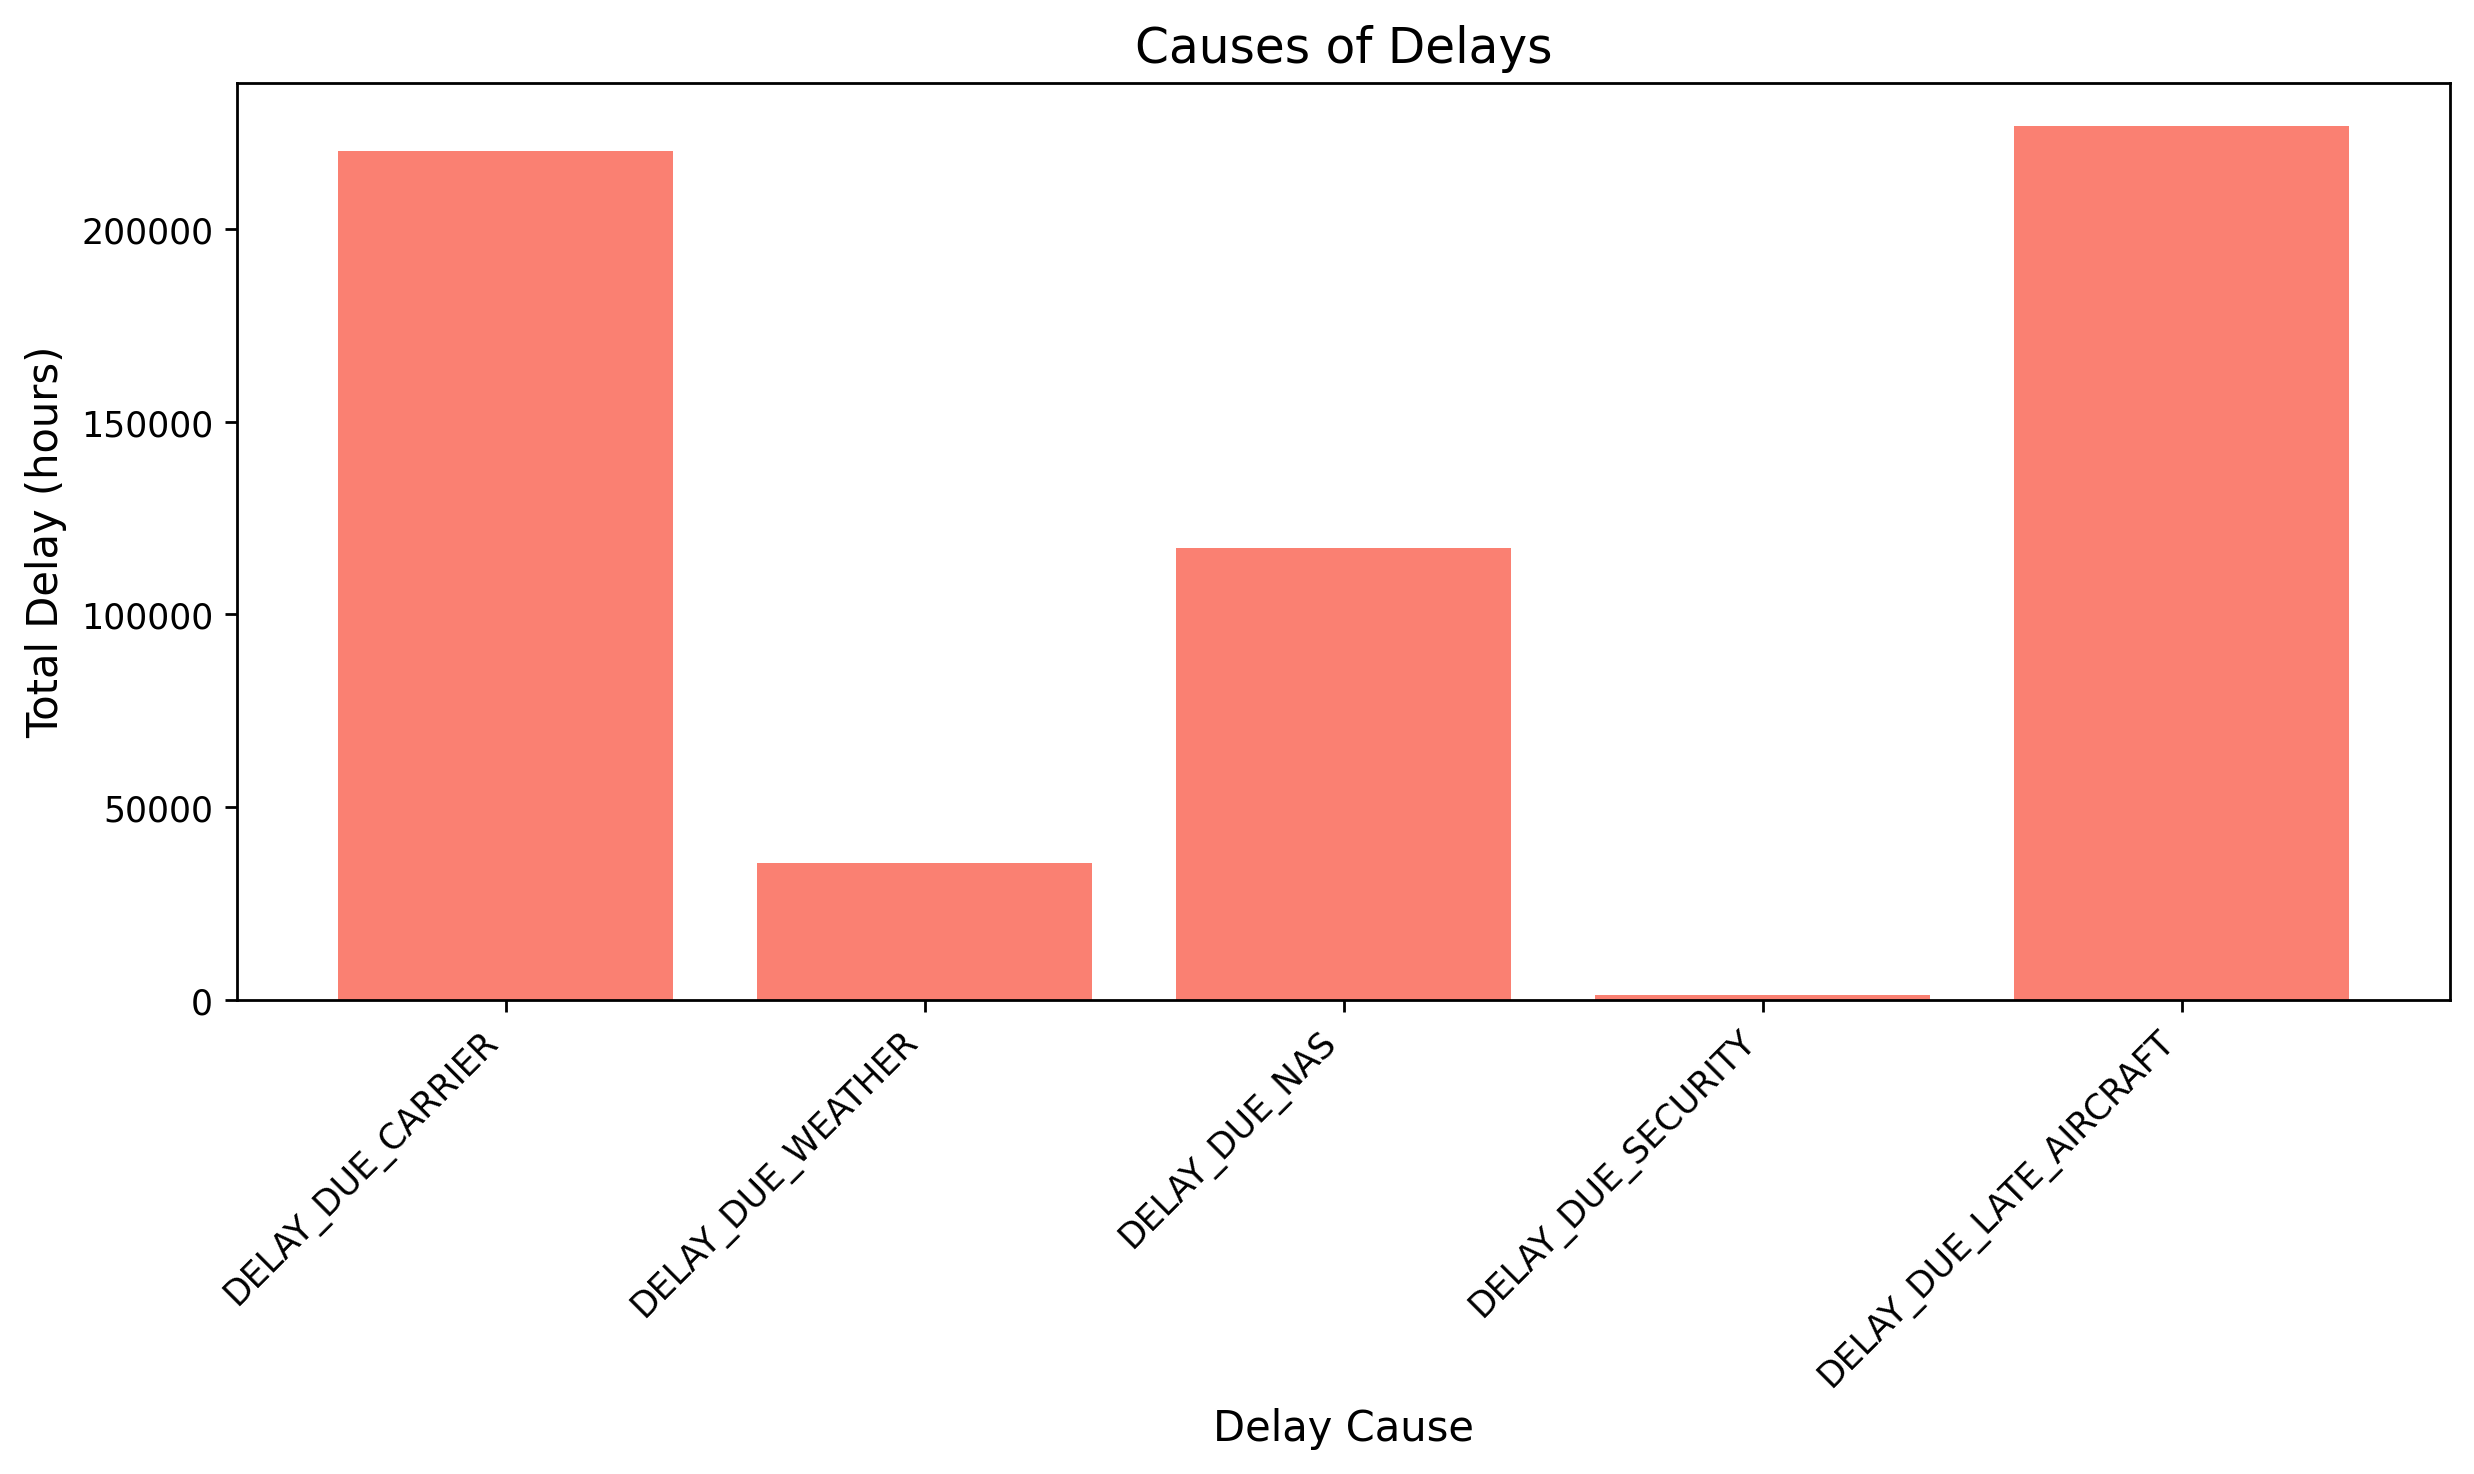

In [11]:
# causes of delays and number of hours of delays they've caused

delay_causes = df[['DELAY_DUE_CARRIER','DELAY_DUE_WEATHER','DELAY_DUE_NAS','DELAY_DUE_SECURITY','DELAY_DUE_LATE_AIRCRAFT']].sum()
delay_causes = (delay_causes / 60) # minutes to hours

plt.figure(figsize = (10,6), dpi = 250)
plt.bar(delay_causes.index, delay_causes.values, color = 'salmon')
plt.xlabel('Delay Cause', fontsize = 12)
plt.xticks(rotation = 45, ha = 'right')
plt.ylabel('Total Delay (hours)', fontsize = 12)
plt.title('Causes of Delays', fontsize = 14)

plt.tight_layout()
plt.show()

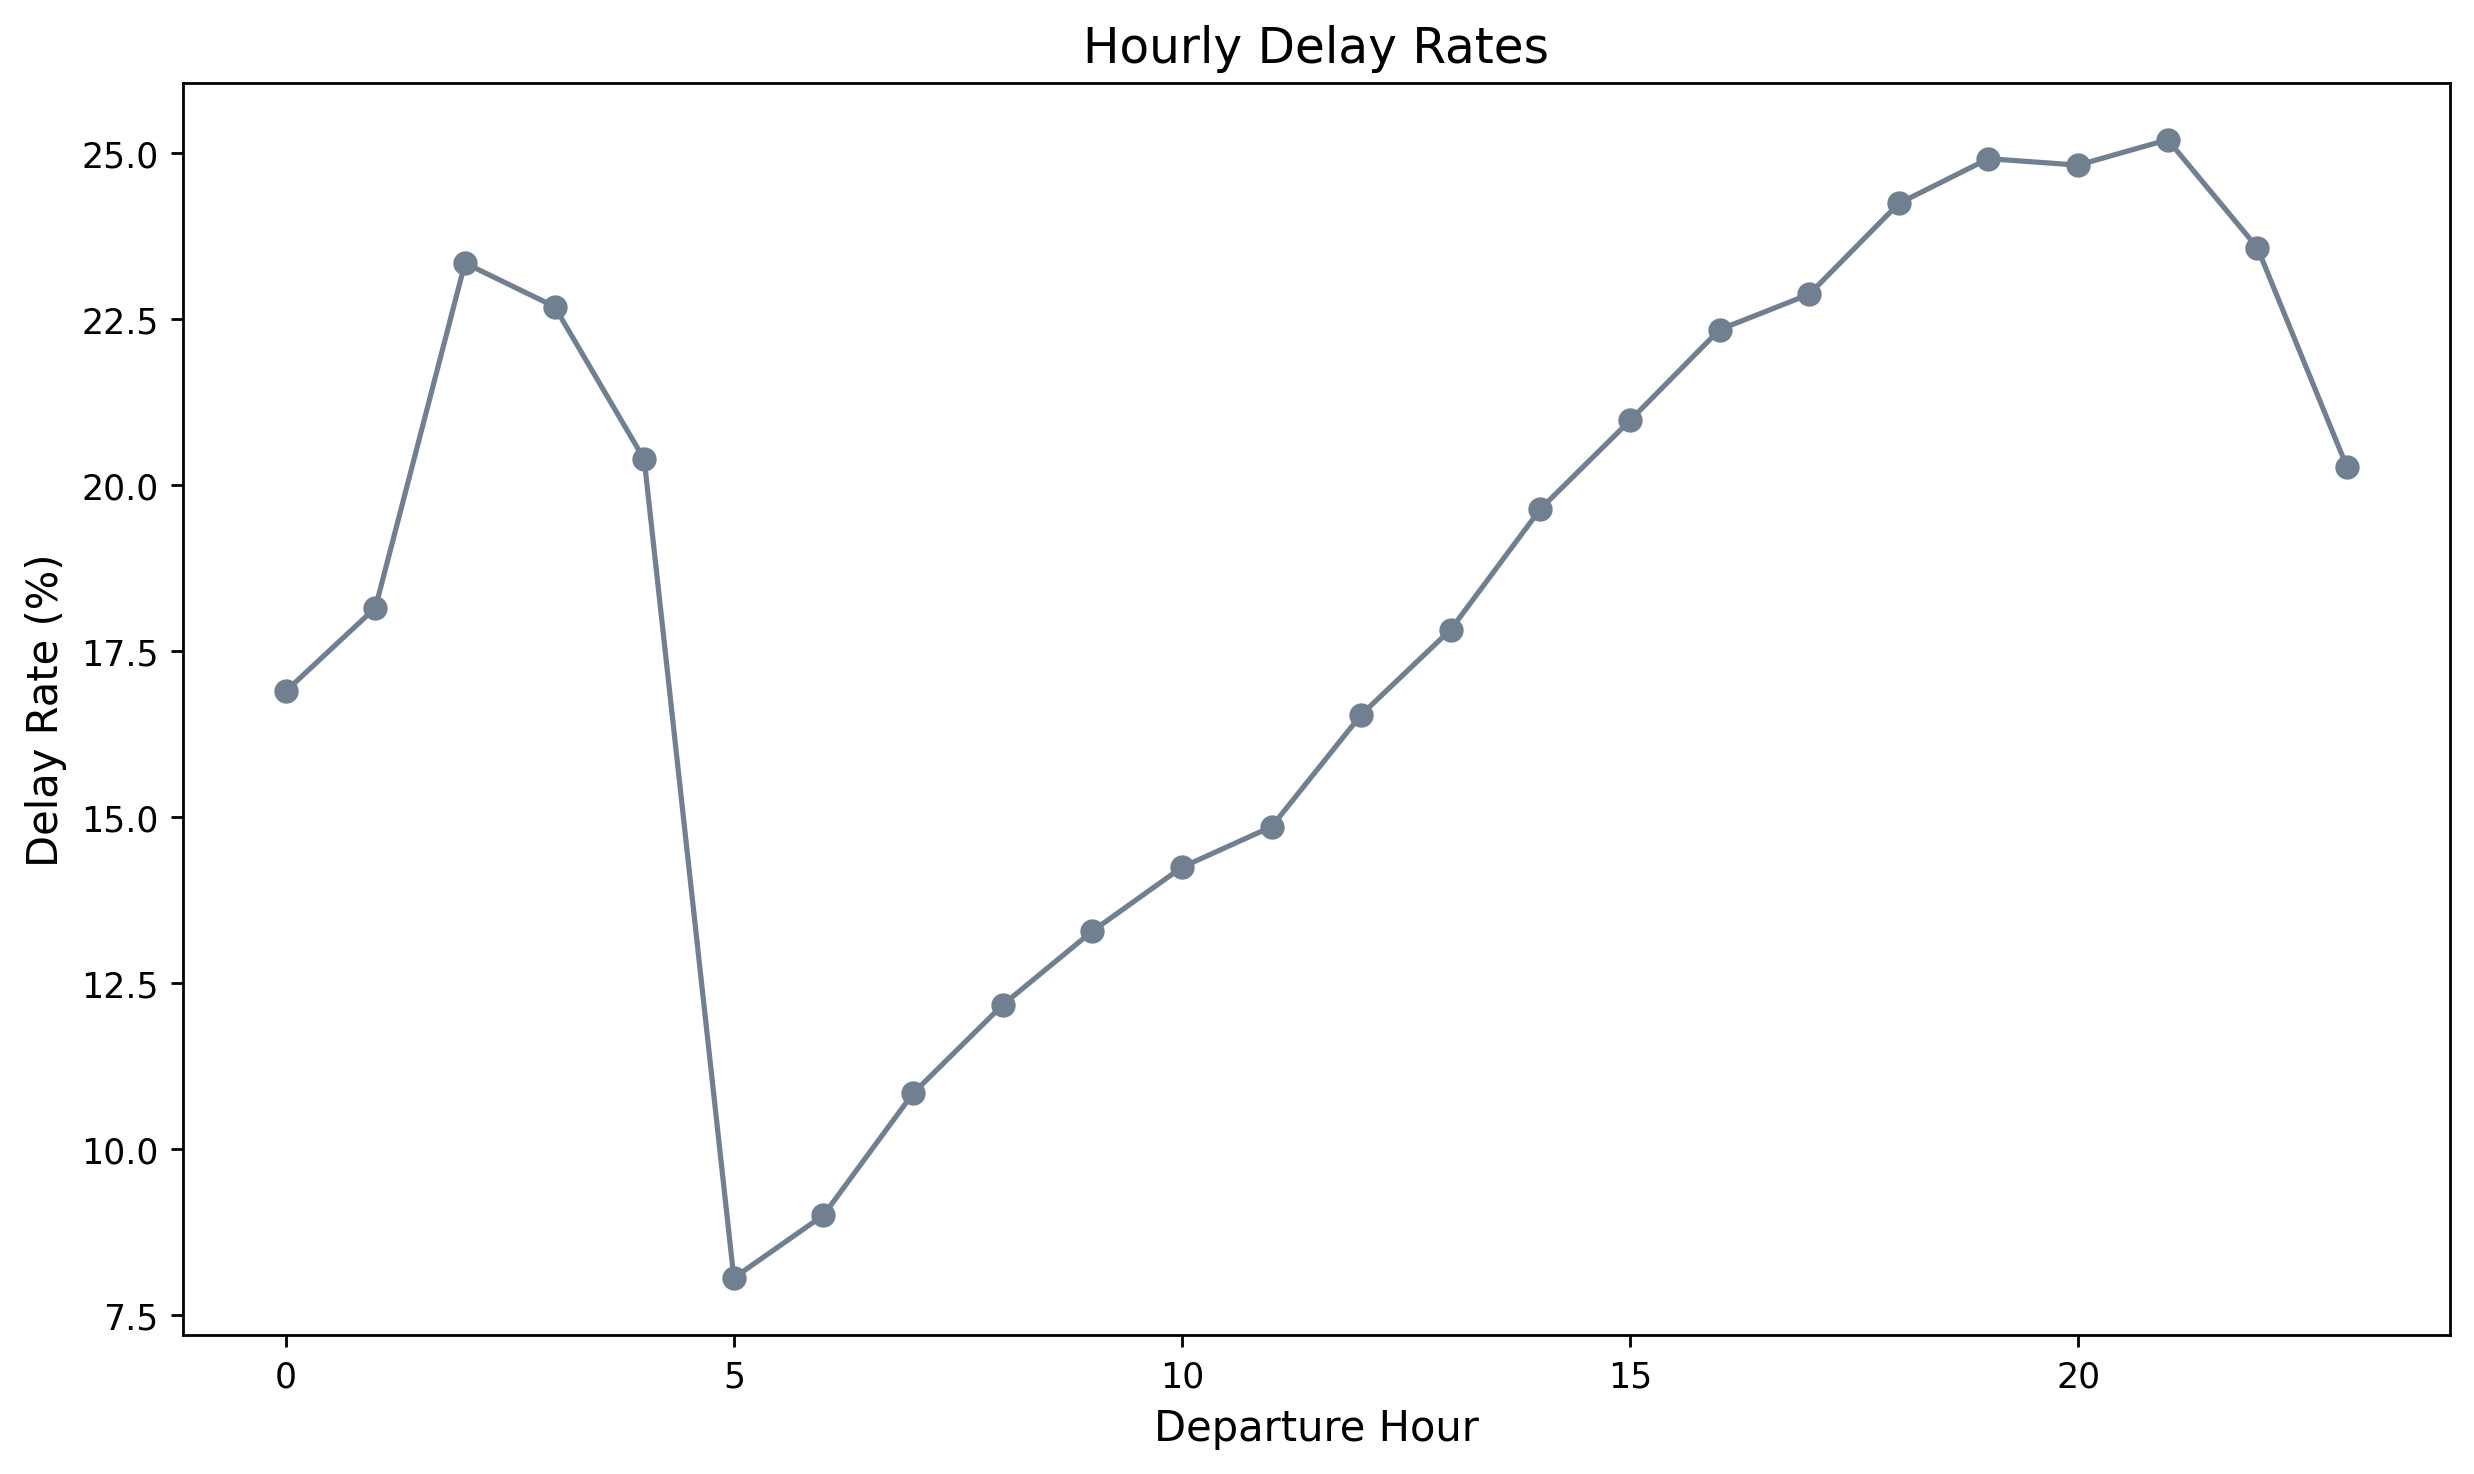

In [12]:
# tracking delay rates by hour (are morning flights less likely to be delayed?)

delay_df['CRS_DEP_HOUR'] = delay_df['CRS_DEP_TIME']//100 # extracts the hour
hourly_delay = delay_df.groupby('CRS_DEP_HOUR')['DELAYED_FLAG'].mean()

#plotting
plt.figure(figsize = (10,6), dpi = 250)
plt.plot(hourly_delay.index, (hourly_delay.values)*100, color = 'slategrey', marker = 'o')
plt.xlabel('Departure Hour', fontsize = 12)
plt.ylabel('Delay Rate (%)', fontsize = 12)
plt.title('Hourly Delay Rates', fontsize = 14)

plt.tight_layout()
plt.show()

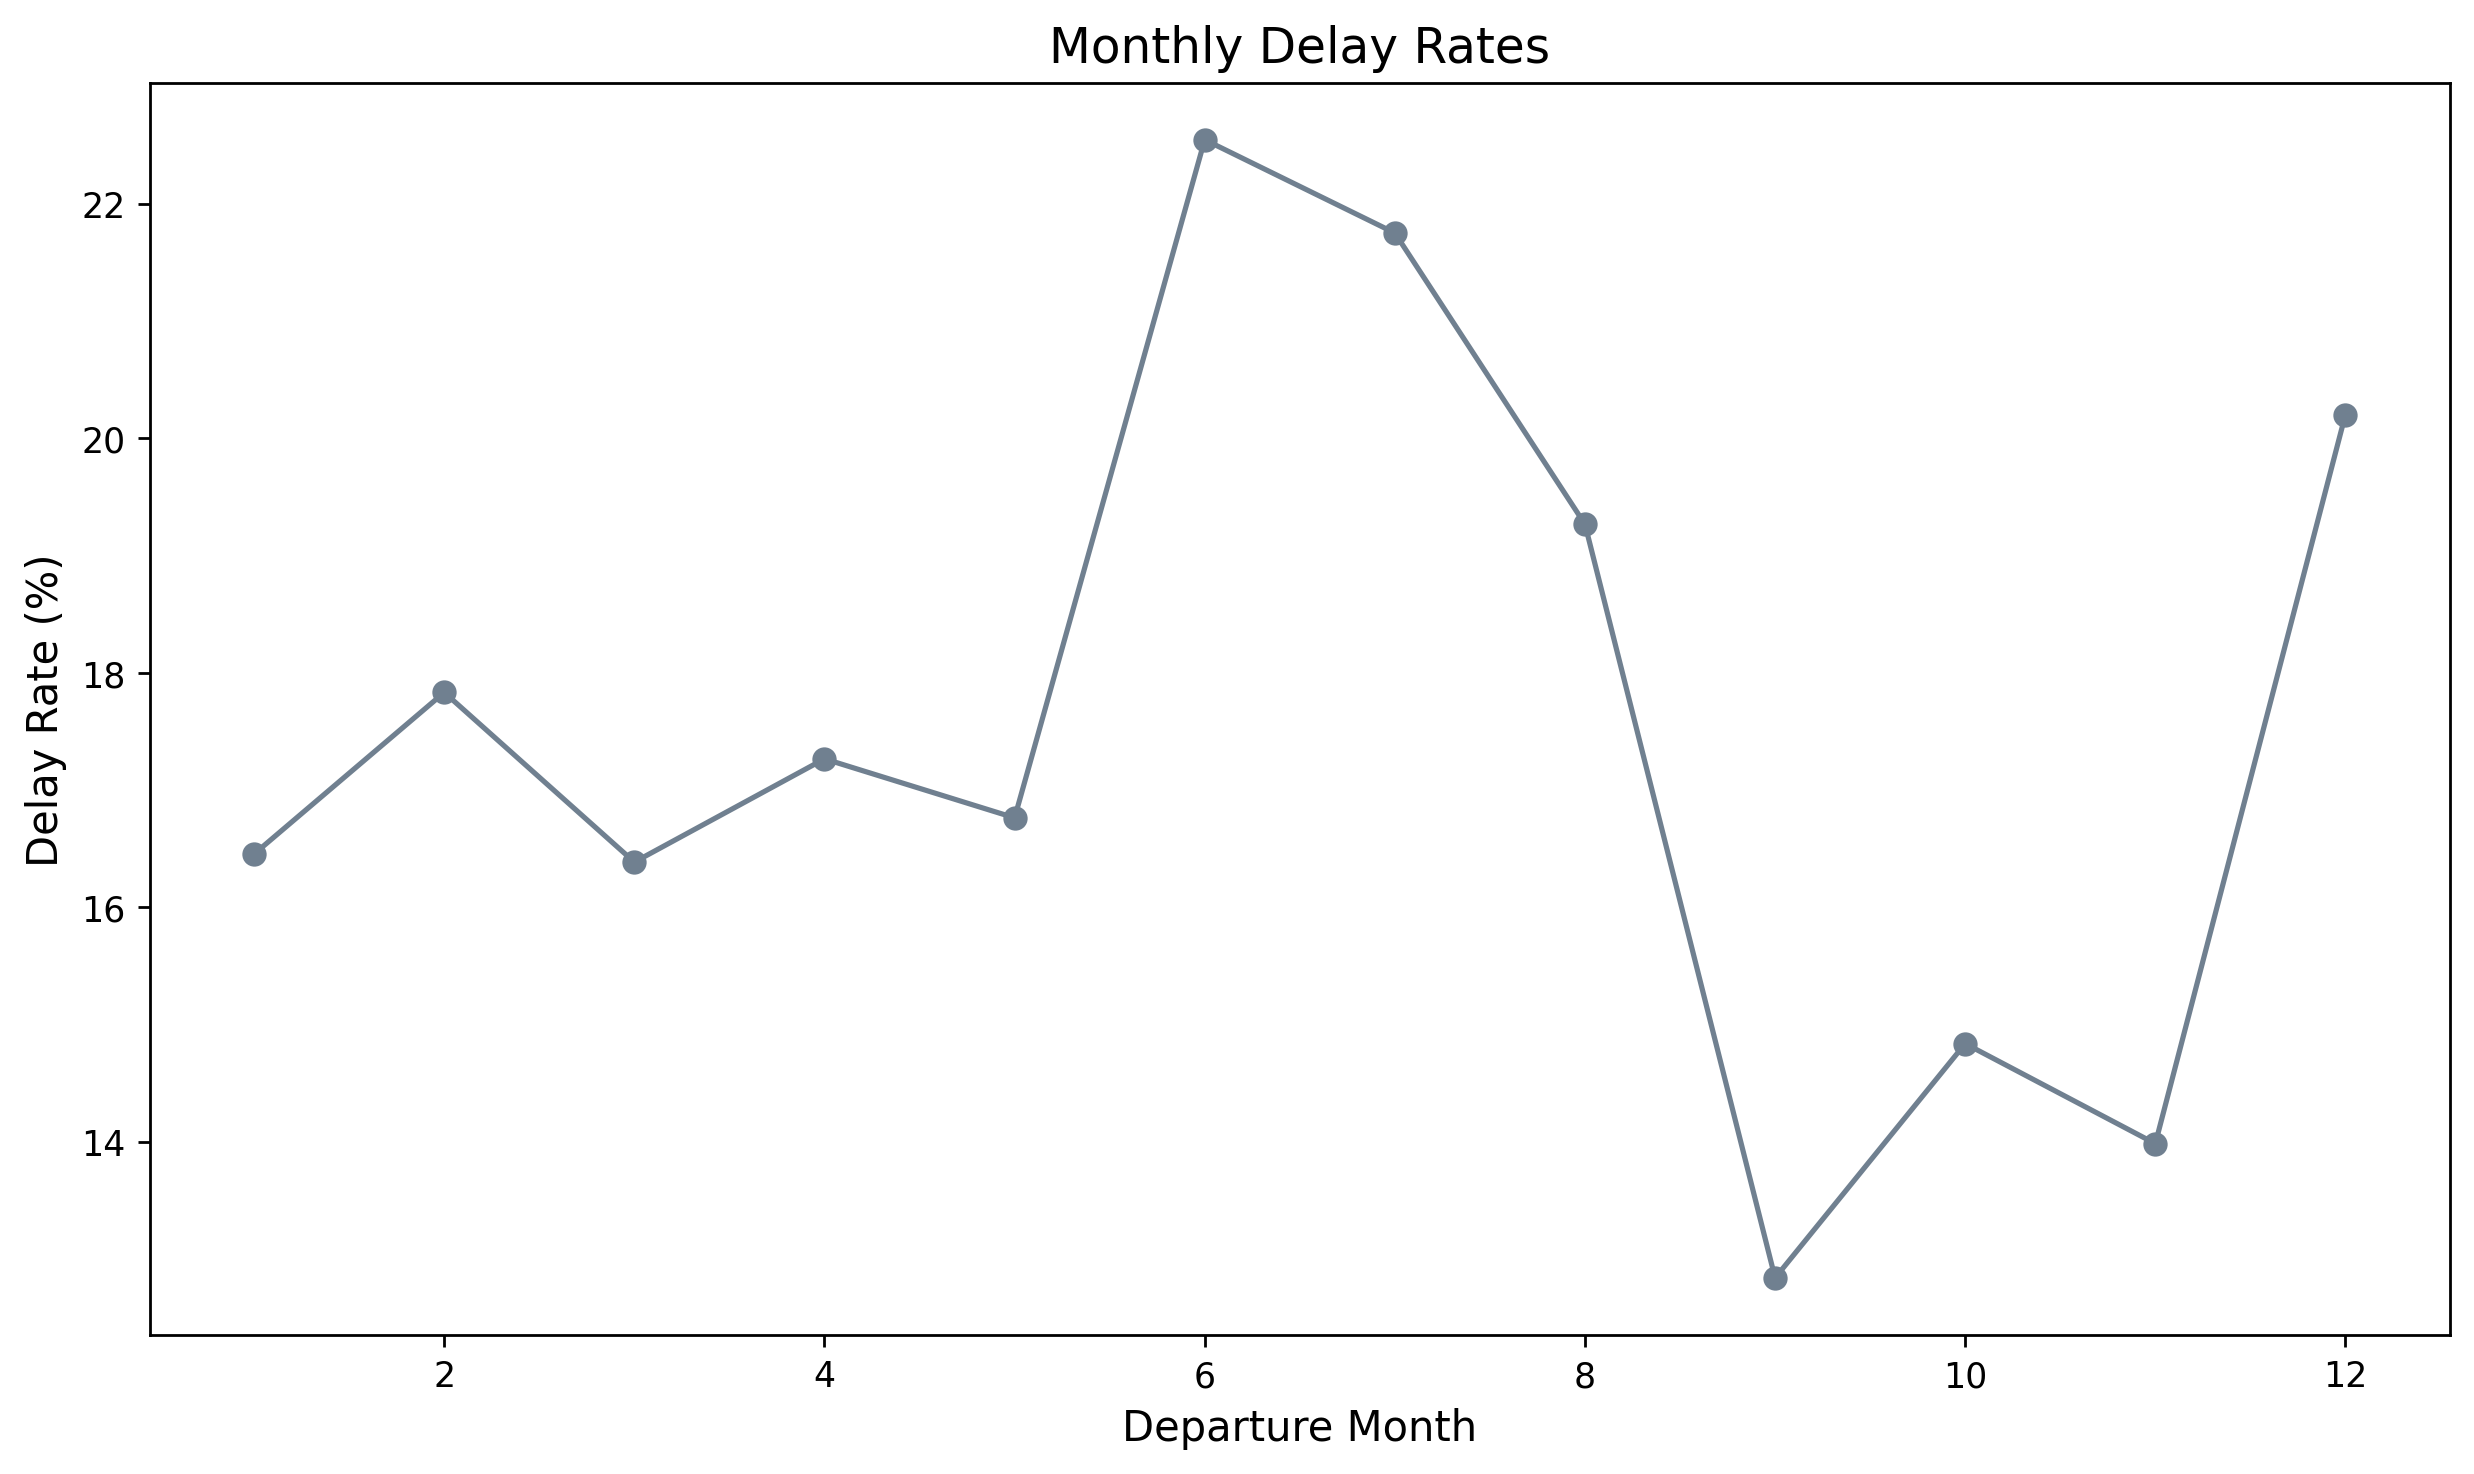

In [13]:
delay_df['MONTH'] = delay_df['FL_DATE'].dt.month
monthly_delay = delay_df.groupby('MONTH')['DELAYED_FLAG'].mean()

#plotting
plt.figure(figsize = (10,6), dpi = 250)
plt.plot(monthly_delay.index, (monthly_delay.values)*100, color = 'slategrey', marker = 'o')
plt.xlabel('Departure Month', fontsize = 12)
plt.ylabel('Delay Rate (%)', fontsize = 12)
plt.title('Monthly Delay Rates', fontsize = 14)

plt.tight_layout()
plt.show()

In [14]:
# making a heatmap for top origins x top destinations

# top 10 busiest origins and destinations
top_origins = delay_df['ORIGIN'].value_counts().head(10).index
top_destinations = delay_df['DEST'].value_counts().head(10).index

# filtering to only those flights
df_top = delay_df[(delay_df['ORIGIN'].isin(top_origins)) &
                  (delay_df['DEST'].isin(top_destinations))]

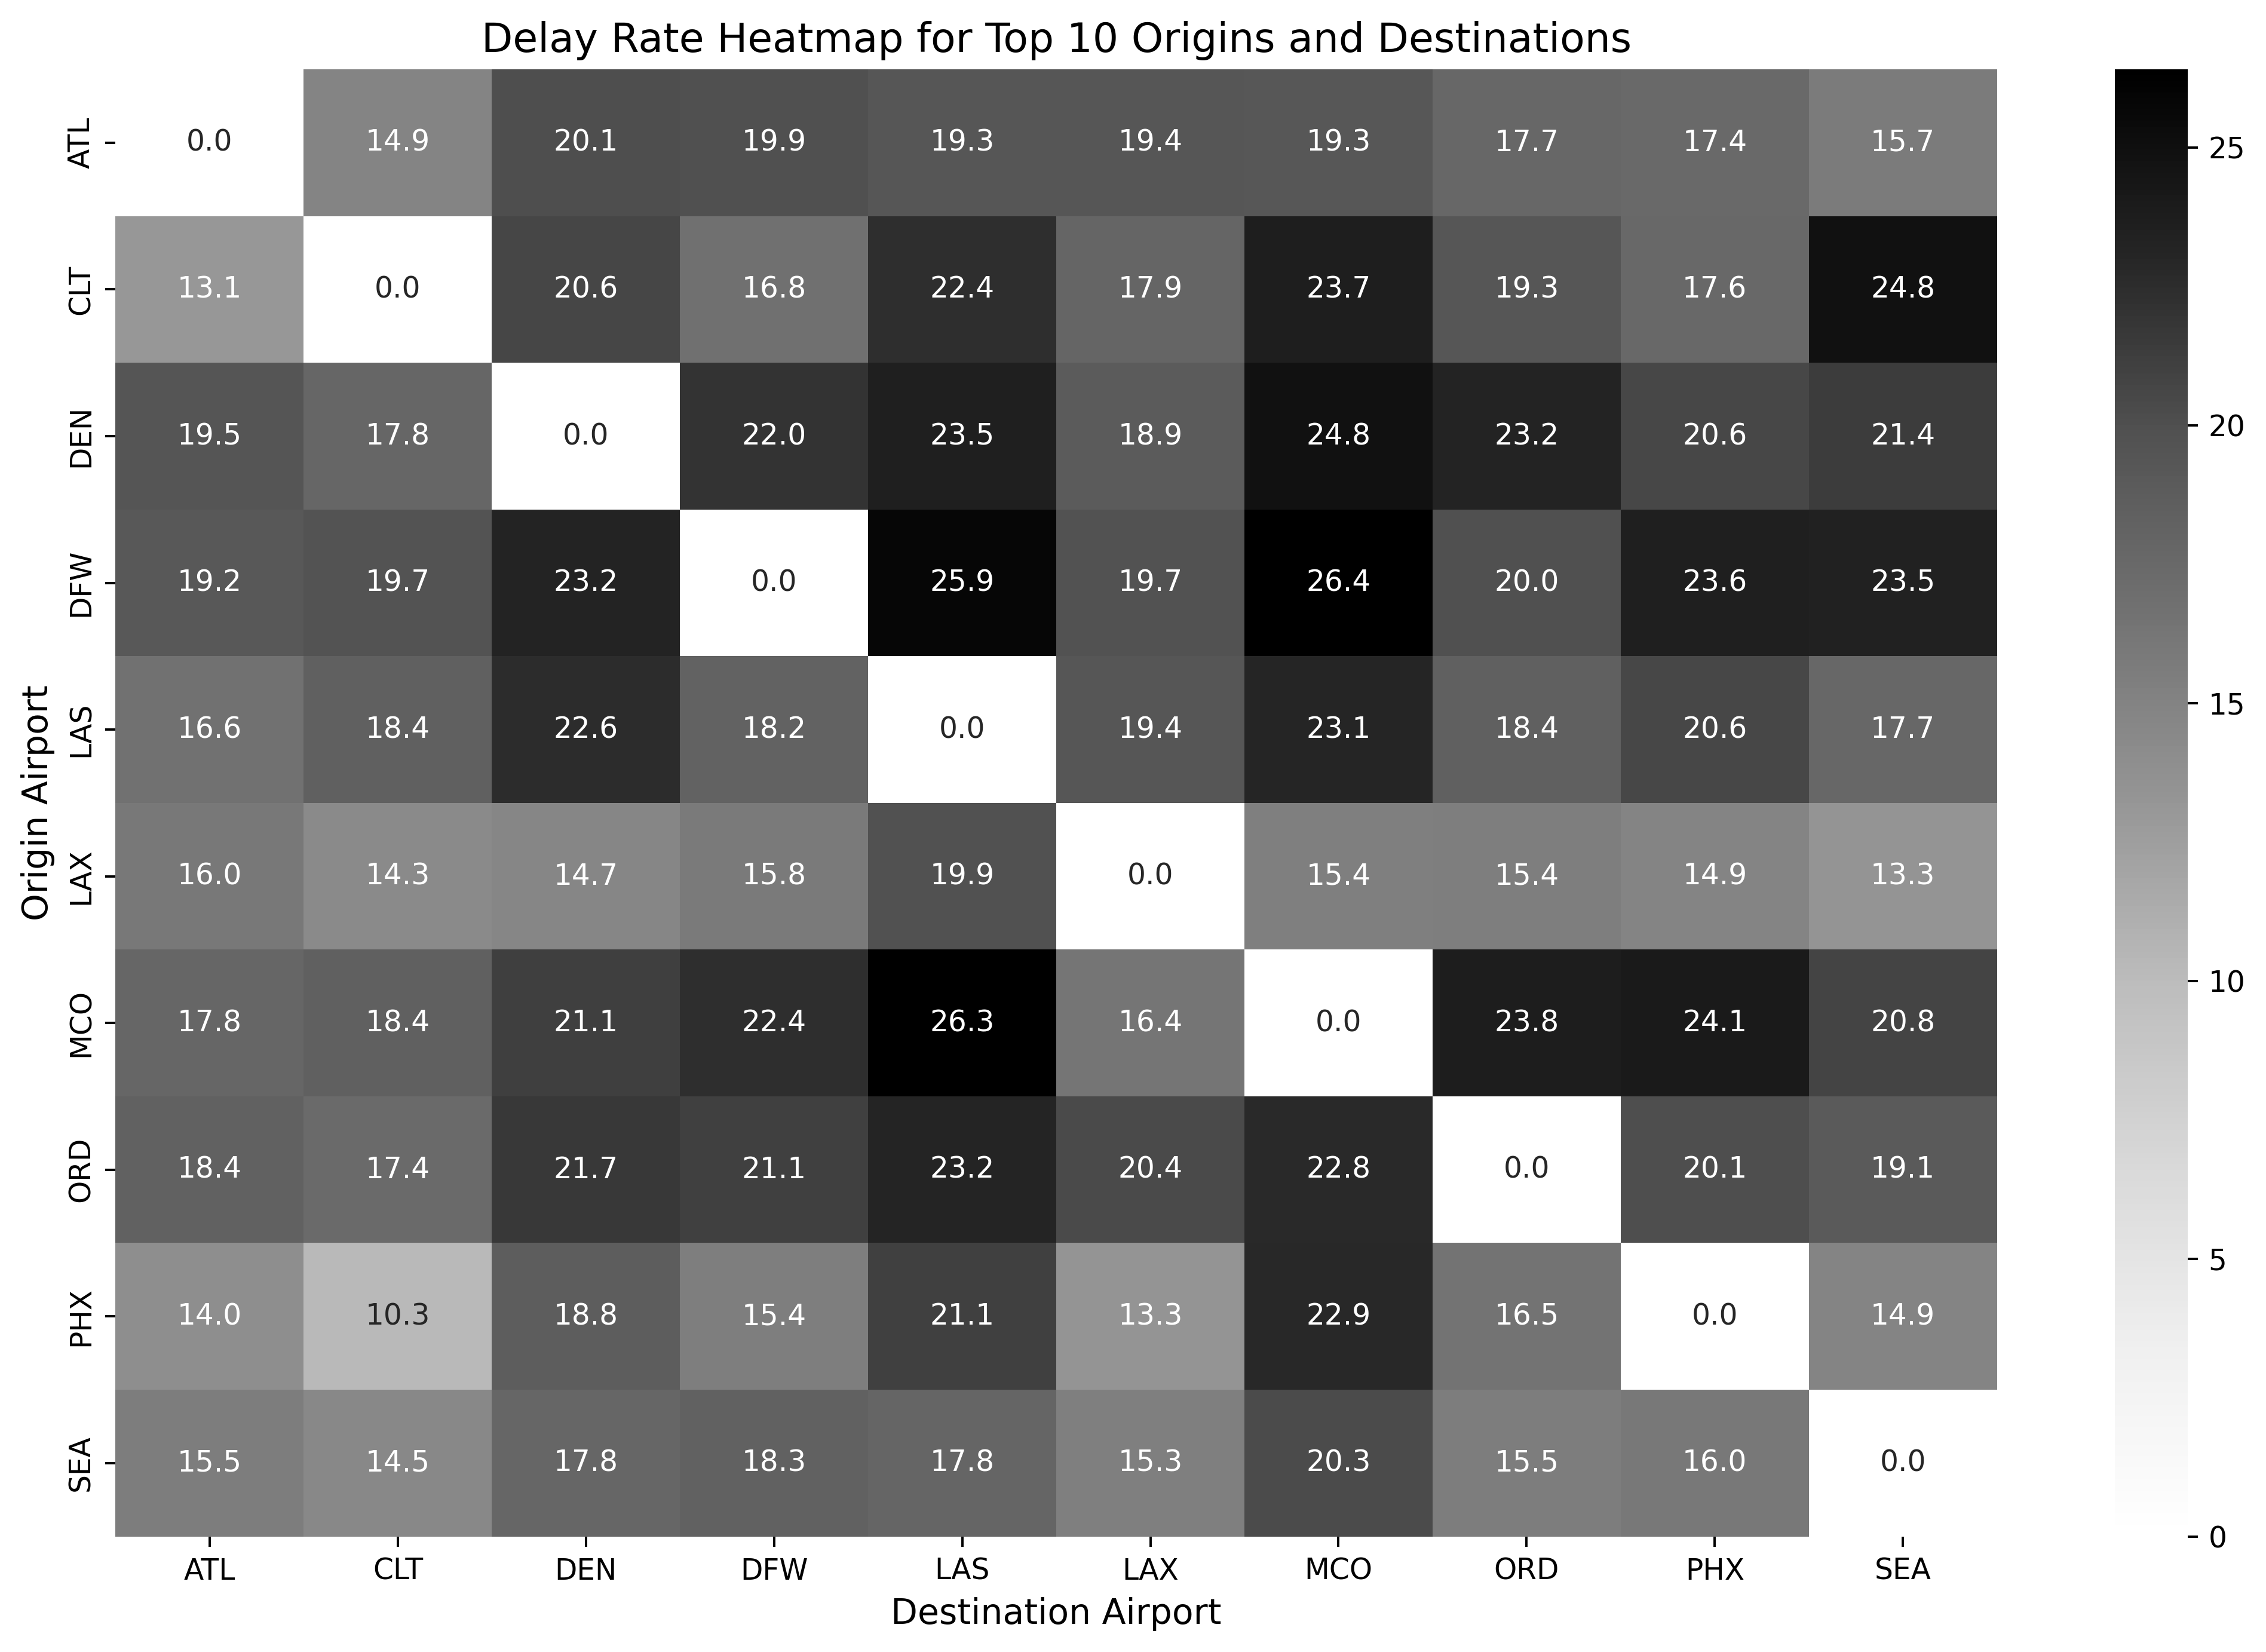

In [105]:
# plotting

heatmap_df = (
    df_top.groupby(['ORIGIN', 'DEST'])['DELAYED_FLAG'].mean()
    .unstack(fill_value=0)   # making a matrix: ORIGIN x DEST
)

plt.figure(figsize = (12, 8), dpi = 350)
sns.heatmap(heatmap_df * 100,    # converting to %
            annot = True,          # writing % on cells
            fmt = '.1f',           # 1 decimal place
            cmap = 'Greys')         # darker = more delay

plt.xlabel('Destination Airport', fontsize = 12)
plt.ylabel('Origin Airport', fontsize = 12)
plt.title('Delay Rate Heatmap for Top 10 Origins and Destinations', fontsize = 14)

plt.tight_layout()
plt.show()

In [16]:
# making a new column for year+month in delay_df
delay_df['YEAR_MONTH'] = delay_df['FL_DATE'].dt.to_period('M')

# filtering out the top 10 airlines by number of flights taken
top_airlines = delay_df['AIRLINE'].value_counts().head(10).index
filtered_df = delay_df[delay_df['AIRLINE'].isin(top_airlines)]

# finding monthly trends for these top 10
monthly_trend = (filtered_df.groupby(['AIRLINE', 'YEAR_MONTH'])['DELAYED_FLAG'].mean().reset_index())
monthly_trend['YEAR_MONTH'] = monthly_trend['YEAR_MONTH'].dt.to_timestamp()

In [18]:
fig = px.line(monthly_trend,
              x = 'YEAR_MONTH',
              y = 'DELAYED_FLAG',
              color = 'AIRLINE',
              labels = {'DELAYED_FLAG': 'Delay Rate', 'YEAR_MONTH': 'Month',  'AIRLINE': 'Airline'},
              title = 'Airline Delay Rate Progression (2019–2023)',
              template='plotly_dark',
)

fig.show()

# Predictive Modeling

After understanding patterns, we built **ML models** to predict whether a flight will be delayed.

Models tested:
- **Logistic Regression** (baseline, interpretable)
- **Random Forest** (nonlinear, handles complex interactions)
- **XGBoost** (boosted trees, state-of-the-art)

Features included:
- Airline
- Origin & destination airports
- Scheduled departure time
- Day and month
- Flight distance


In [36]:
# assigning dependent and independent variables

delay_df['DAY_OF_WEEK'] = delay_df['FL_DATE'].dt.day
features = ['AIRLINE', 'ORIGIN', 'DEST', 'CRS_DEP_TIME', 'DAY_OF_WEEK', 'MONTH', 'DISTANCE']
X = delay_df[features]
y = delay_df['DELAYED_FLAG']


In [27]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size = 0.2, random_state = 14
)

In [74]:
# creating the pipeline (onehotencoder for cat variables, scaler for numerical variables)

from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

categorical = ['AIRLINE', 'ORIGIN', 'DEST']
numeric = ['CRS_DEP_TIME', 'DAY_OF_WEEK', 'MONTH', 'DISTANCE']

preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown = 'ignore'), categorical),
        ('num', StandardScaler(), numeric)
    ]
)

In [31]:
# running the logistic regression

from sklearn.linear_model import LogisticRegression

log_reg = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(max_iter = 500, class_weight='balanced'))
])

In [32]:
log_reg.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['AIRLINE', 'ORIGIN',
                                                   'DEST']),
                                                 ('num', StandardScaler(),
                                                  ['CRS_DEP_TIME',
                                                   'DAY_OF_WEEK', 'MONTH',
                                                   'DISTANCE'])])),
                ('classifier',
                 LogisticRegression(class_weight='balanced', max_iter=500))])

In [40]:
#logistic regression report

from sklearn.metrics import classification_report, confusion_matrix

y_pred = log_reg.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.87      0.60      0.71    479915
           1       0.24      0.60      0.34    102846

    accuracy                           0.60    582761
   macro avg       0.56      0.60      0.53    582761
weighted avg       0.76      0.60      0.64    582761



In [75]:
# upgrading to random forest

from sklearn.ensemble import RandomForestClassifier

rf_model = Pipeline(steps = [
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(
         n_estimators = 50,       # number of trees
        max_depth = 15,          # depth of trees
        class_weight = 'balanced', # handling class imbalance
        random_state = 42,
        n_jobs = -1               # using all CPU cores for speed
    ))
])

In [78]:
rf_model.fit(X_train, y_train)

KeyboardInterrupt: 

In [76]:
# random forest report

from sklearn.metrics import classification_report

rf_pred = rf_model.predict(X_test)
print(classification_report(y_test, rf_pred))

NotFittedError: Pipeline is not fitted yet.

In [65]:
# checking which features affect rf decisions the most

rf_clf = rf_model.named_steps['classifier']
rf_importances = rf_clf.feature_importances_

rf_imp_df = pd.DataFrame({
    'Feature': preprocessor.get_feature_names_out(),
    'RF_Importance': rf_importances
}).sort_values('RF_Importance', ascending=False)

In [67]:
# upgrading to xgboost

from xgboost import XGBClassifier

xgb_model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', XGBClassifier(
        n_estimators = 200,        # number of boosting rounds
        max_depth = 6,             # shallower trees (since boosting doesn’t need deep trees)
        learning_rate = 0.1,       # how much each tree corrects the previous one
        subsample = 0.8,           # using 80% of data for each tree (speed + generalization)
        colsample_bytree = 0.8,    # using 80% of features for each tree
        scale_pos_weight = len(y_train[y_train==0]) / len(y_train[y_train==1]),  # handling imbalance
        random_state = 14,
        n_jobs = -1
    ))
])


In [80]:
xgb_model.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['AIRLINE', 'ORIGIN',
                                                   'DEST']),
                                                 ('num', StandardScaler(),
                                                  ['CRS_DEP_TIME',
                                                   'DAY_OF_WEEK', 'MONTH',
                                                   'DISTANCE'])])),
                ('classifier',
                 XGBClassifier(base_score=None, booster=None, callbacks=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree...
                               feature_types=None, feature_weights=None,
                               gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=0.1,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=6, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=200, n_jobs=-1,
                               num_parallel_tree=None, ...))])

In [81]:
# xgboost report

xgb_preds = xgb_model.predict(X_test)

from sklearn.metrics import classification_report
print(classification_report(y_test, xgb_preds))

              precision    recall  f1-score   support

           0       0.88      0.64      0.74    479915
           1       0.26      0.60      0.37    102846

    accuracy                           0.63    582761
   macro avg       0.57      0.62      0.55    582761
weighted avg       0.77      0.63      0.67    582761



In [108]:
# checking which features affect xgb decisions the most

xgb_clf = xgb_model.named_steps['classifier']  # grabbing the trained XGB model
feature_names = preprocessor.get_feature_names_out()

importances = xgb_clf.feature_importances_  # default = 'gain'
feat_imp_df = pd.DataFrame({'Feature': feature_names, 'XGB_Importance': importances})
feat_imp_df = feat_imp_df.sort_values('XGB_Importance', ascending = False)
feat_imp_df

,Feature,XGB_Importance
10,cat__AIRLINE_JetBlue Airways,0.025254
1,cat__AIRLINE_Allegiant Air,0.019951
3,cat__AIRLINE_Delta Air Lines Inc.,0.019924
15,cat__AIRLINE_Southwest Airlines Co.,0.019825
4,cat__AIRLINE_Endeavor Air Inc.,0.019640
...,...,...
157,cat__ORIGIN_GCK,0.000000
415,cat__DEST_ALW,0.000000
418,cat__DEST_APN,0.000000
419,cat__DEST_ART,0.000000


## Model Comparison & Key Findings

- Logistic Regression achieved **60% accuracy** — limited by its linear nature.
- Random Forest improved recall but leaned heavily on **departure time** (44% of importance).
- XGBoost balanced feature contributions better, spreading importance across **airlines** and **airports**.

This suggests:
- **Departure time** is a simple but strong signal for delays.
- **Airline/airport factors** add nuance, which tree-based models capture better.

In [95]:
compare_df = pd.merge(
    rf_imp_df,
    feat_imp_df[['Feature','XGB_Importance']],  # from XGB
    on = 'Feature')

In [98]:
# tagging each feature with a category

def categorize_feature(name):
    if 'AIRLINE' in name:
        return 'Airline'
    elif 'ORIGIN' in name:
        return 'Origin Airport'
    elif 'DEST' in name:
        return 'Destination Airport'
    elif 'CRS_DEP_TIME' in name:
        return 'Departure Time'
    elif 'DISTANCE' in name:
        return 'Distance'
    else:
        return 'Other'

compare_df['Category'] = compare_df['Feature'].apply(categorize_feature)

# grouping importances by category
grouped = compare_df.groupby('Category')[['RF_Importance','XGB_Importance']].sum().reset_index()

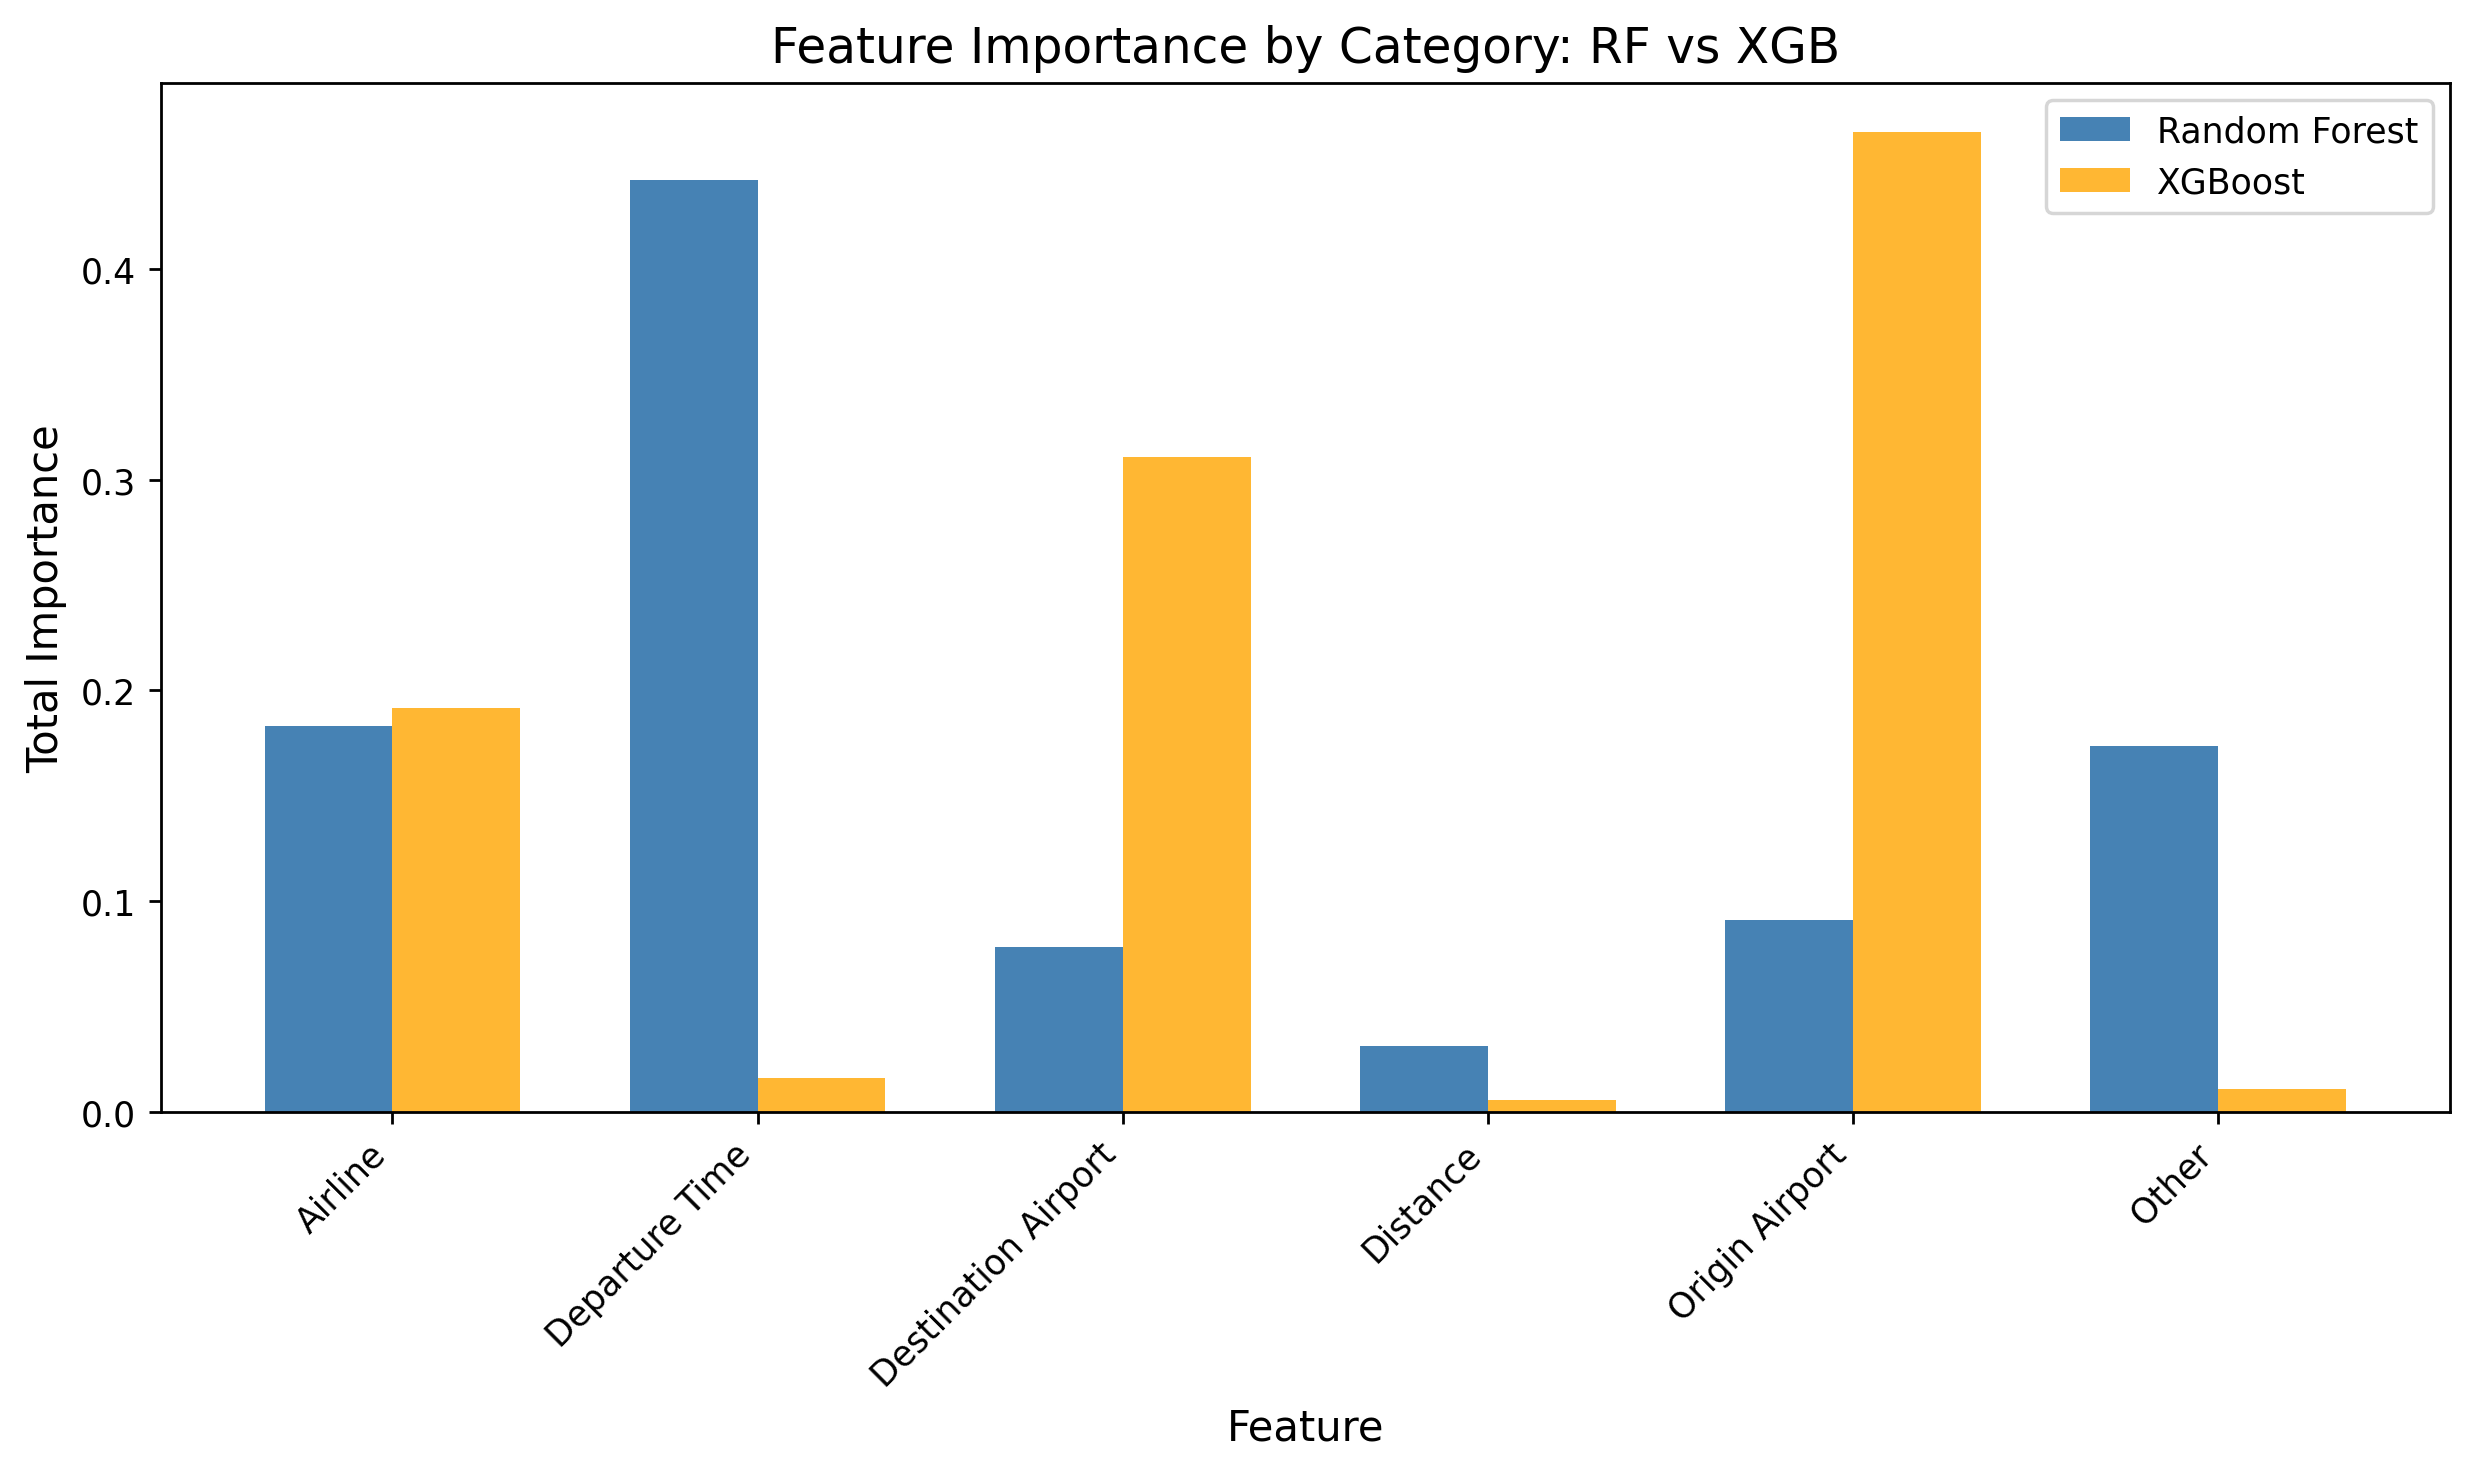

In [104]:
# plotting side-by-side bars

x = np.arange(len(grouped))
width = 0.35

plt.figure(figsize = (10,6), dpi = 250)
plt.bar(x - width/2, grouped['RF_Importance'], width, label = 'Random Forest', color = 'steelblue')
plt.bar(x + width/2, grouped['XGB_Importance'], width, label = 'XGBoost', color = 'orange', alpha = 0.8)

plt.xlabel('Feature', fontsize = 12)
plt.xticks(x, grouped['Category'], rotation = 45, ha='right')
plt.ylabel('Total Importance', fontsize = 12)
plt.title('Feature Importance by Category: RF vs XGB', fontsize = 14)
plt.legend()

plt.tight_layout()
plt.show()

# Conclusion & Key Takeaways

### Key Insights

- **XGBoost vs Random Forest:**  
   - Random Forest leaned very heavily on **departure time** (44% of its importance), treating it as the dominant driver of delays.  
   - XGBoost, on the other hand, spread importance more evenly — highlighting **airline** and **airport factors** alongside timing, suggesting a **richer understanding** of delay patterns.  

- **Airline & Route Patterns:** Certain airlines and origin-destination pairs consistently show **higher delay rates**, offering a clear picture of where operational improvements could have the greatest impact.  

- **Seasonality & Trends:** The month-wise delay progression (2019–2023) revealed not just seasonal patterns (e.g., summer peaks) but also **macro disruptions** like the COVID dip in 2020 and its uneven recovery.  

---

### Why This Matters

- **For Airlines:**  
  Pinpoint where and when delays happen most often — and whether they’re rooted in scheduling, airports, or uncontrollable factors.

- **For Airports & Regulators:**  
  Insights on **high-delay routes** and periods can inform **infrastructure and staffing decisions**.

- **For Passengers:**  
  A data-backed sense of **which flights are most likely to be delayed**, aiding in smarter travel decisions.
  
---

### Next Steps I (or you, if you want) might take (Future Extensions)

- **External data**: Bring in weather or holiday data to explain more of the variance in delays.  
- **Deployment**: Package as an **interactive dashboard** (Streamlit or Dash) to let users query delay risk by airline, route, or time of day.

---

**Bottom line:**  
This project moved from **exploratory analysis** to **predictive modeling** and clear **operational insights** — demonstrating how raw flight data can be transformed into **actionable intelligence** for multiple stakeholders.
